In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
path = "watermelon_4.0.txt"
data_str = []
with open(path) as fr:
    lines = fr.readlines()
    for line in lines:
       data_str.append(line.split())
data = np.array(data_str).astype(np.float64)

In [3]:
def random_choose(data_, k):
    m = data_.shape[0]
    return data_[np.random.choice(m, k, replace=False)]

In [4]:
def dist(a, b, norm=2, ax=0):
    return ((np.abs(np.array(a) - np.array(b)) 
             ** norm).sum(axis=ax)) ** (1 / norm)

In [5]:
def plus_plus_choose(data, k, norm):
    m = data.shape[0]
    # method of k_means++ to choose mean vector
    mean_list = [np.random.choice(m, 1)]
    means = np.array(data[mean_list[0]])
    for i in range(k - 1):
        dis = np.zeros(m)
        for j in range(means.shape[0]):
            dis += dist(means[j], data, norm, ax=1)
        far_arg = dis.argsort()[::-1]
        for idx in range(len(far_arg)):
            if far_arg[idx] not in mean_list:
                mean_list.append(far_arg[idx])
                means = np.concatenate((means, [data[far_arg[idx]]]), axis=0)
                # print(far_arg[idx])
                break
            else:
                continue
    # print(means)
    return means

In [6]:
def k_means(data_set, k, method='pp',norm=2):
    m = data_set.shape[0]
    well_splited = False
    while not well_splited:
        if method == 'random':
            mean_vector = random_choose(data_set, k)
        elif method == 'pp':
            mean_vector = plus_plus_choose(data_set, k, norm)
        else:
            raise ValueError("Unsloved method [%s]" % method)
        Flag = True
        while Flag:
            C = []
            for i in range(k + 1):
                C.append([])
            for j in range(m):
                dj = ((np.abs((data_set[j] - mean_vector)
                          ** norm).sum(axis=1)) ** (1 / norm)).argmin()
                C[dj].append(data_set[j].tolist())
            mean_prev = mean_vector.copy()
            for i in range(k):
                mean_vector[i] = np.array(C[i]).mean(axis=0).tolist()
            mean_delta = np.min(np.abs(mean_prev - mean_vector))
            if mean_delta == 0.0:
                Flag = False
        C[k] = mean_vector[:].tolist()
        # check zero split
        sub_shape = k_shape(C)
        if 1 not in sub_shape:
#             print("Well Generated")
            well_splited = True
#         else:
#             print("Generate again...")
    return C

In [7]:
def plot_res(C_set):
    # print(len(C_set))
    k = len(C_set)-1
    color_dict = ['red', 'blue', 'yellow', 
                  'green', 'gray', 'purple', 
                  'orange', 'cyan', 'pink', 
                  'black']
    for i in range(k):
        plt.scatter(
            np.array(C_set[i])[:, 0],
            np.array(C_set[i])[:, 1],
            color=color_dict[i])
        for pt in C_set[i]:
            plt.plot(
                [pt[0], C_set[-1][i][0]],
                [pt[1], C_set[-1][i][1]],
                color='black',
                linewidth=0.8)
    plt.scatter(
        np.array(C_set[-1])[:, 0],
        np.array(C_set[-1])[:, -1],
        color=color_dict[k],
        marker='x',
        s=50)
    plt.title(k)

In [8]:
def k_shape(split_list):
    k_l = []
    for i in range(len(split_list)):
        k_l.append(len(split_list[i]))
    return k_l

In [10]:
def avg(C, norm=2):
    m_C = len(C)
    avg_c = 0.0
    for k in range(m_C):
        for i in range(len(C[k])):
            for j in range(i+1, len(C[k])):
               avg_c += dist(C[k][i], C[k][j], norm)
    avg_c = 2 * avg_c / (m_C * (m_C - 1))
    return avg_c

In [11]:
def DBI(C, norm=2):
    m_C = len(C) - 1
    db_i = 0.0
    for i in range(m_C):
        i_max = 0
        for j in range(i+1, m_C):
            tt = avg(C[i]) + avg(C[j])
            dist_ij = dist(C[m_C][i], C[m_C][j])
            # print(1/dist_ij)
            tt /= dist_ij
            if tt > i_max:
                i_max = tt
        db_i += i_max
    db_i /= m_C
    # print(m_C)
    return db_i

In [12]:
def k_means_auto(data_set, method='pp', norm=2, min_split=2):
    C = {}
    C_DBI = {}
    for i in range(min_split, 9):
        C[i] = k_means(data_set, i, norm=norm)
        C_DBI[i] = DBI(C[i], norm)
    best_ks = sorted(C_DBI,key=lambda x:C_DBI[x])[0]
    plot_res(C[best_ks])
    
    k_data = C[best_ks]
    k_res = []
    for i in range(best_ks):
        i_res = []
        for j in range(len(k_data[i])):
            i_res.append(np.where(data==k_data[i][j])[0][0])
        k_res.append(i_res)
    return best_ks, k_res

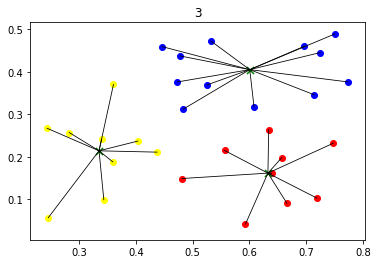

In [14]:
k, k_res = k_means_auto(data, method='pp', norm=2, min_split=3)